In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import IsolationForest

# Load dataset

In [2]:
from sklearn.datasets import load_wine

wine = load_wine(return_X_y=False)
X = pd.DataFrame(wine.data, columns=wine.feature_names)
X.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



# Train a ML model

In [3]:
model = IsolationForest(behaviour="new", contamination="auto")
model.fit(X)

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

# Define the game

In [4]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

## Choose an anomaly $x$

In [5]:
idx_anomaly = np.argwhere(model.predict(X) == -1).flatten()
idx_x = np.random.choice(idx_anomaly, size=1)[0]
x = X.iloc[idx_x,:]
x

alcohol                          12.79
malic_acid                        2.67
ash                               2.48
alcalinity_of_ash                22.00
magnesium                       112.00
total_phenols                     1.48
flavanoids                        1.36
nonflavanoid_phenols              0.24
proanthocyanins                   1.26
color_intensity                  10.80
hue                               0.48
od280/od315_of_diluted_wines      1.47
proline                         480.00
Name: 151, dtype: float64

## Choose a reference $r$

In [6]:
idx_normal = np.argwhere(model.predict(X) == 1).flatten()
idx_r = np.random.choice(idx_normal, size=1)[0]
r = X.iloc[idx_r,:]
r

alcohol                           14.39
malic_acid                         1.87
ash                                2.45
alcalinity_of_ash                 14.60
magnesium                         96.00
total_phenols                      2.50
flavanoids                         2.52
nonflavanoid_phenols               0.30
proanthocyanins                    1.98
color_intensity                    5.25
hue                                1.02
od280/od315_of_diluted_wines       3.58
proline                         1290.00
Name: 6, dtype: float64

## Reward function

In [7]:
def fc(z):
    if model.decision_function(z.reshape(1,-1)) < 0:
        return 1
    else:
        return 0

# Approximation methods

## Monte Carlo 

In [8]:
def MonteCarloShapley(x, fc, r, n_iter):
    """
    Estimate the Shapley Values using an optimized Monte Carlo version.
    """
    # Get general information
    f_r = fc(r.values)
    feature_names = list(x.index)
    d = len(feature_names) # dimension
    
    # Store Shapley Values in a pandas Series
    Φ_storage = np.empty((n_iter,d))

    # Monte Carlo loop
    for m in range(1, n_iter+1):
        # Sample a random permutation order
        o = np.random.permutation(d)
        # init useful variables for this iteration
        f_less_j = f_r
        x_plus_j = r.values.copy()
        for j in o:
            x_plus_j[j] = x.values[j]
            f_plus_j = fc(x_plus_j)
            # update Φ 
            Φ_j = f_plus_j - f_less_j
            Φ_storage[m-1,j] = Φ_j
            # reassign f_less_j
            f_less_j = f_plus_j

    Φ = pd.Series(np.mean(Φ_storage,axis=0), index=feature_names)
    return Φ

In [9]:
mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=5)
mc_shap

alcohol                        -0.2
malic_acid                      0.2
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.2
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.2
proanthocyanins                 0.2
color_intensity                 0.2
hue                             0.6
od280/od315_of_diluted_wines   -0.2
proline                        -0.2
dtype: float64

# Comparison with several references in the inlier class

In [10]:
n_ref = 10
idx_r = np.random.choice(idx_normal, size=n_ref).flatten()
pool_ref = X.iloc[idx_r,:]
pool_ref.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
155,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0
89,12.08,1.33,2.30,23.6,70.0,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625.0
92,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0
104,12.51,1.73,1.98,20.5,85.0,2.20,1.92,0.32,1.48,2.94,1.04,3.57,672.0
79,12.70,3.87,2.40,23.0,101.0,2.83,2.55,0.43,1.95,2.57,1.19,3.13,463.0


In [11]:
x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
pool_shapley = pd.DataFrame(np.zeros((n_ref, d)), columns=x_attributes)
for i in range(n_ref): 
    mc_shap = MonteCarloShapley(x=x, fc=fc, r=r, n_iter=5)
    pool_shapley.iloc[i,:] = mc_shap.values

In [12]:
mean_pool_shap = pool_shapley.mean(axis=0)
mean_pool_shap

alcohol = 12.79                       -0.14
malic_acid = 2.67                      0.02
ash = 2.48                             0.00
alcalinity_of_ash = 22.0              -0.04
magnesium = 112.0                      0.18
total_phenols = 1.48                   0.18
flavanoids = 1.36                      0.00
nonflavanoid_phenols = 0.24            0.02
proanthocyanins = 1.26                 0.10
color_intensity = 10.8                 0.46
hue = 0.48                             0.34
od280/od315_of_diluted_wines = 1.47    0.02
proline = 480.0                       -0.14
dtype: float64

In [13]:
np.sum(mean_pool_shap)

1.0000000000000002

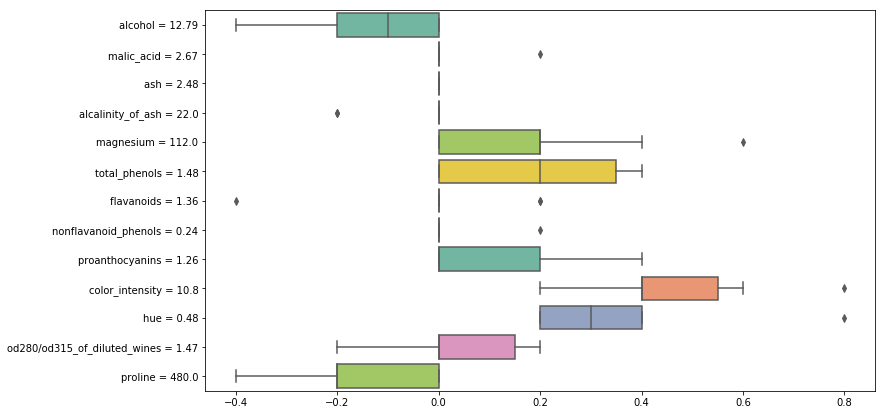

In [14]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=pool_shapley, orient="h", palette="Set2")
plt.show()